In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
# Set Important Values

data = '/data/dww78/mini_inat_val/'
gpu = 1
torch.cuda.set_device(gpu)
workers = 8
epoch = 10
start_epoch = 0
vbity = 20
esize = 2

way = 20
evalway = 5
trainshot = 5
testshot = 5

In [3]:
# Load Training/Testing Data
threshold = .15
d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, msize, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (msize,msize), mode='constant', cval=0, anti_aliasing=False)
        t = [t, (torch.FloatTensor(mask-threshold).sign()/2+.5).unsqueeze(0)]
    return t

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            pcount = np.array([len(trackdict[k]) for k in list(trackdict.keys())])
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False, p=pcount/sum(pcount))
            for cat in cats:
                for _ in range(trainshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(testshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < trainshot+testshot:
                    trackdict.pop(cat)
            # TODO: shuffle idlist batches
            yield idlist
            idlist = []

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, 21, True, True))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, 21, False, True))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
681 227


In [4]:
# Make Models

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class PROTO(nn.Module):
    def __init__(self):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            Block(64,64)
        )
        
    def forward(self, inp):
        return self.process(inp)
        
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, inp, masks, way, trainshot):
        support = inp[:way*trainshot].unsqueeze(-1) # B 64 21 21 1
        m = masks.unsqueeze(1) # B 1 21 21
        c = torch.stack([1-m, m], dim=-1) # B 1 21 21 2     (Positive class corresponds to index/label 1)
        c = (c*support).contiguous().view(way,trainshot,inp.size(1),-1,2).mean(3).mean(1) # W 64 2
        c = c.unsqueeze(2).unsqueeze(2).unsqueeze(1) # W 1 64 1 1 2
        
        query = inp[way*trainshot:].view(way, -1, inp.size(1), inp.size(2), inp.size(3), 1) # W S 64 21 21 1
        
        distmat = ((c-query)**2).sum(2).neg().view(-1, inp.size(2), inp.size(3), 2) # B 21 21 2
        probs = self.sm(distmat)
        return probs
    
smodel = [PROTO().cuda() for i in range(esize)]
predictor = Predictor().cuda()
soptimizer = [optim.Adam(m.parameters(), lr=.001) for m in smodel]
sscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in soptimizer]
criterion = nn.NLLLoss().cuda()

nweights = sum([i.numel() for i in list(smodel[0].parameters())])
print(nweights," parameters in each neural net.")

113088  parameters in each neural net.


In [5]:
# Define the Procedures

def train(train_loader, epoch, gpu, vbity):
    for model in smodel:
        model.train()
    allloss = [0]*esize
    for i, ((inp,m), _) in enumerate(train_loader):
        im = Variable(inp).cuda(device = gpu, async=True) # B 3 84 84
        m = Variable(m).cuda(device = gpu, async=True) # B 1 21 21
        mask = m[:way*trainshot] 
        targ = m[way*trainshot:].long() 
        
        for j in range(esize):
            smodel[j].zero_grad()
            out = predictor(smodel[j](im), mask, way, trainshot)
            loss = criterion(out.view(-1,2), targ.view(-1))
            loss.backward()
            soptimizer[j].step()
        
            allloss[j] += loss.item()
            
        if i%vbity == 0:
            print('%d of approx. 192270'%(i*way*(trainshot+testshot)))
    return [L/i for L in allloss]

def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, ((inp,m), _) in enumerate(val_loader):
            im = Variable(inp).cuda(device = gpu, async=True) # B 3 84 84
            m = Variable(m).cuda(device = gpu, async=True) # B 1 21 21
            mask = m[:evalway*trainshot] 
            targ = m[evalway*trainshot:].long() 

            with torch.no_grad():
                for j in range(esize):
                    out = predictor(smodel[j](im), mask, evalway, trainshot)
                    loss = criterion(out.view(-1,2), targ.view(-1))
                    allloss[j] += loss.item()
                    _,pred = torch.max(out,-1)
                    intersection = (pred*targ).view(testshot*evalway,-1).sum(-1).float()
                    union = (1-(1-targ)*(1-pred)).view(testshot*evalway,-1).sum(-1).float()+.0001
                    acc = (intersection/union).mean().item()
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(trainshot+testshot)))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

print('Ready to go!')

Ready to go!


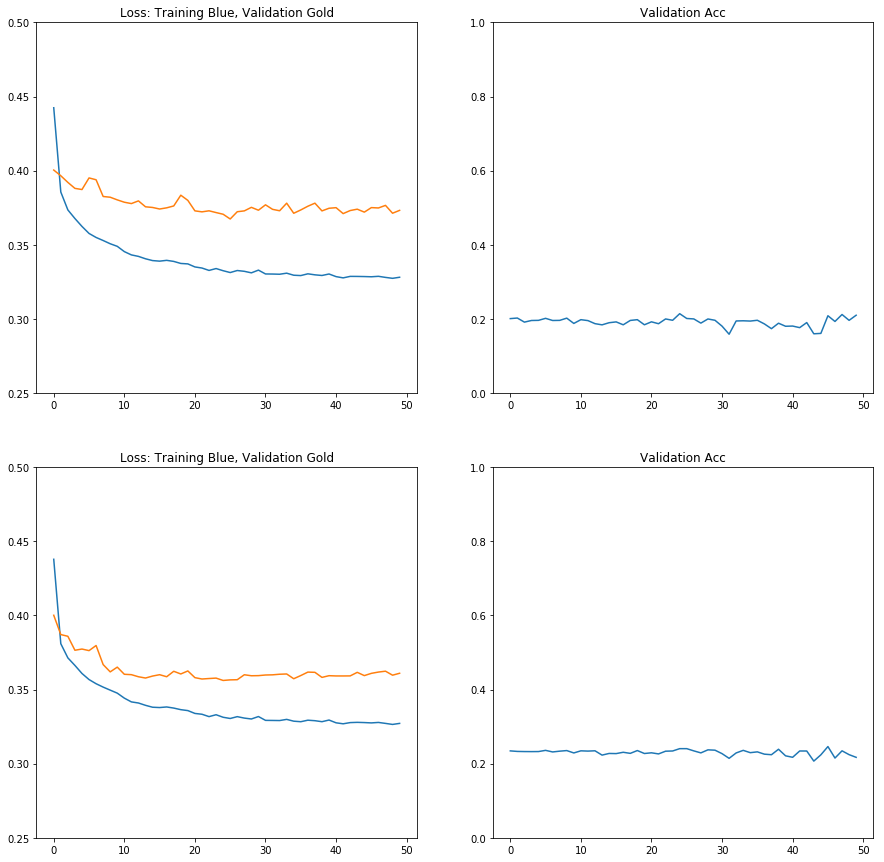

Train loss is: [0.32809635668384785, 0.3271669879657071]
Validation accuracy is: [0.2008051664318357, 0.23449164202383585]
Validation loss is: [0.3732089101927231, 0.3609794062355563]

0.14 hours to completion

7.202376542157597 hours total
Model 0 final score: 19.95 +- 0.08
Model 1 final score: 23.31 +- 0.10


In [6]:
# Do the Thing!

start = time.time()
trainlosses, testlosses, acctracker = [[] for _ in range(esize)],[[] for _ in range(esize)],[[] for _ in range(esize)]
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in sscheduler]
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, _ = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    for j in range(esize):
        trainlosses[j].append(trainloss[j])
        testlosses[j].append(testloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(esize):
        pl.subplot(esize,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.plot(testlosses[i])
        pl.ylim((.25,.5))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(esize,2,2*i+2)
        pl.plot(acctracker[i][::-1])
        pl.ylim((0,1))
        pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600, "hours total") 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

In [7]:
torch.save(smodel[0].cpu().state_dict(), 'detector_TEMP_smallbatch.pth')

In [6]:
i = 0
smodel[i].load_state_dict(torch.load('detector_TEMP_smaller2.pth'))
model = smodel[i].cuda()

In [8]:
for (inp, m), targ in test_loader:
    inp = Variable(inp).cuda(device = gpu, async=True) # B 3 84 84
    m = Variable(m).cuda(device = gpu, async=True) # B 1 21 21
    mask = m[:evalway*trainshot]
    targ = m[evalway*trainshot:].long()

    out = model(inp)
    pred = predictor(out, mask, evalway, trainshot)
    
    break

In [83]:
n = 47
m = n+evalway*trainshot

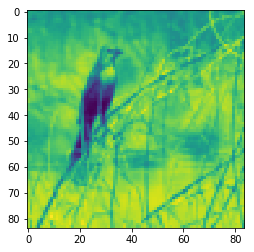

In [84]:
pl.imshow(inp[m][0].data.cpu().numpy())

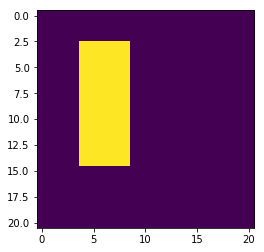

In [85]:
t = targ[n].squeeze()
pl.imshow(t.data.cpu().squeeze().numpy())

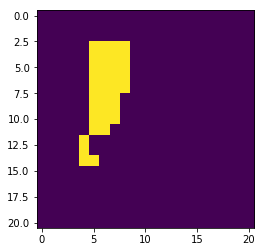

In [86]:
_,p = torch.max(pred[n],-1)
pl.imshow(p.data.cpu().squeeze().numpy())

In [87]:
intersection = (p*t).sum()
union = (1-(1-t)*(1-p)).sum()
print(intersection.item(), union.item(), intersection.item()/union.item())

35 60 0.5833333333333334
